In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # attractive vizualization of data representation
import wordcloud

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import bq_helper
stackoverflow = bq_helper.BigQueryHelper("bigquery-public-data", "stackoverflow")

#answers = pd.read_csv('../input/AnswersScores.csv', header=0)

# Any results you write to the current directory are saved as output.

['extracted-so-dataset']
Using Kaggle's public dataset BigQuery integration.


# Explanation of Dataset:

So, In this kernel I used two datasets:
- 1) bigquery-public-data of Stack Overflow and 
- 2) I extracted other data from the Stack Overflow Query editor (SEDE Stack Exchange) beceause Google BigQuery SQL editor has few limitations that means tested query that works on MSSQL environment or Stack Overflow Query editor that does not working on the Google big query editor. So, I extracted data from SO online database and Create datasets on Kaggle for my convinience. 

In [22]:
stackoverflow.list_tables()
#stackoverflow.head("posts_questions",num_rows=5)

['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

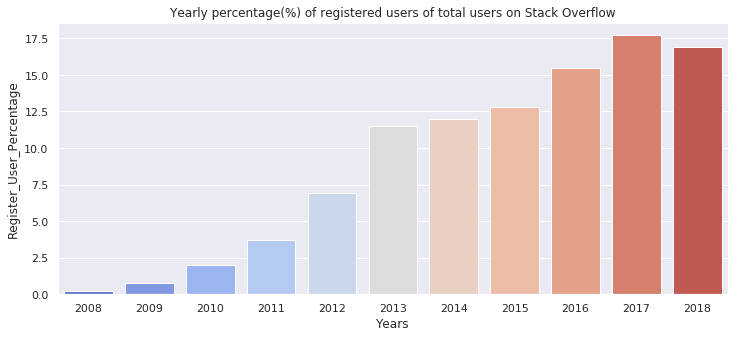

In [23]:
#Registered users yearly on Stack Overflow
percentageUsers = """select EXTRACT(YEAR FROM creation_date) Years, count(*) usersYearly,
ROUND(100*count(*)/9804894,1) as Register_User_Percentage
FROM `bigquery-public-data.stackoverflow.users`
where EXTRACT(YEAR FROM creation_date) <= 2018
group by EXTRACT(YEAR FROM creation_date)"""

peryearlyusers = stackoverflow.query_to_pandas(percentageUsers)
dfUsers  = pd.DataFrame(peryearlyusers)
#dfUsers
#dfUsers.plot.bar()
ax = sns.barplot(x = "Years",y = "Register_User_Percentage",
data = peryearlyusers,palette="coolwarm").set_title("Yearly percentage(%) of registered users of total users on Stack Overflow")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [24]:
#Active users yearly on Stack Overflow who have posted 5 or more questions or answers on SO
activeUsers = """WITH RunTotalTestData AS (
  SELECT * FROM UNNEST([STRUCT(1 AS Year, 1 AS runningTotal),
  (2008,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2008)),
  (2009,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2009)),
  (2010,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2010)),
  (2011,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2011)),
  (2012,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2012)),
  (2013,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2013)),
  (2014,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2014)),
  (2015,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2015)),
  (2016,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2016)),
  (2017,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2017)),
  (2018,(select count(*) from `bigquery-public-data.stackoverflow.users` where EXTRACT(YEAR FROM creation_date) = 2018))
  ]) 
)
select A.Years, A.runningTotalUsers UsersRunningTotalYearly,A.ActiveusersYearly ActiveUsersYearly, 
ROUND(100*A.ActiveusersYearly/A.runningTotalUsers,1) as ActiveUsersPercentageYearly from (
select resulttable.Years Years, count(resulttable.OwnerUserId) ActiveusersYearly,
(select B.runningTotal from RunTotalTestData B where B.Year = resulttable.Years) runningTotalUsers
    from (
    select EXTRACT(YEAR FROM posts.creation_date) Years, posts.owner_user_id OwnerUserId,  count(*) AskedQuestion5  
    from `bigquery-public-data.stackoverflow.posts_questions` AS posts 
    where posts.owner_user_id is not null 
    and EXTRACT(YEAR FROM posts.creation_date) <= 2018
    group by EXTRACT(YEAR FROM posts.creation_date), posts.Owner_User_Id
    union all
    select EXTRACT(YEAR FROM posts.creation_date) Years, posts.owner_user_id OwnerUserId,  count(*) AskedQuestion5  
    from `bigquery-public-data.stackoverflow.posts_answers` AS posts 
    where posts.owner_user_id is not null 
    and EXTRACT(YEAR FROM posts.creation_date) <= 2018
    group by EXTRACT(YEAR FROM posts.creation_date), posts.Owner_User_Id
    
        ) resulttable 
where resulttable.AskedQuestion5 > 4
group by resulttable.Years
) A
order by A.Years"""
yearlyactiveUsers = stackoverflow.query_to_pandas(activeUsers)


# Total registered users and active users on Stack Overflow Yearly.
- Active Users: I Identified a users as a active if the users post 5 or more questions or answers yearly.
- Registered users: here we calculated the users who registeded on Stack Overflow yearly.

,Years,UsersRunningTotalYearly,ActiveUsersYearly,ActiveUsersPercentageYearly
0,2008,21676,10490,48.4
1,2009,78121,36975,47.3
2,2010,199458,63806,32.0
3,2011,359295,108754,30.3
4,2012,680175,155697,22.9


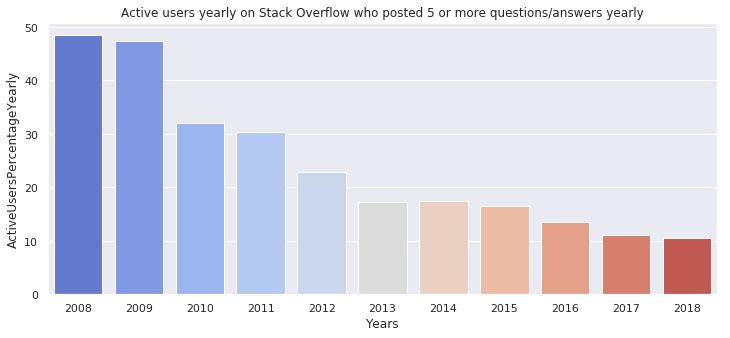

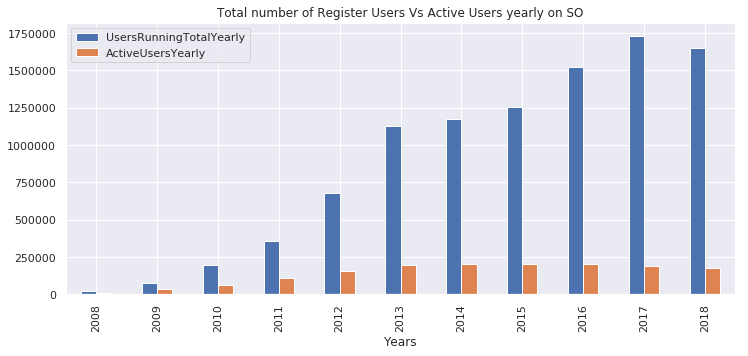

In [42]:
ax = sns.barplot(x = "Years",y = "ActiveUsersPercentageYearly",
data = yearlyactiveUsers,palette="coolwarm").set_title("Active users yearly on Stack Overflow who posted 5 or more questions/answers yearly")
sns.set(rc={'figure.figsize':(12,5)})
ax1= yearlyactiveUsers.plot(x="Years",y=["UsersRunningTotalYearly","ActiveUsersYearly"], 
kind="bar",figsize=(12,5),title='Total number of Register Users Vs Active Users yearly on SO')
#ax1.set(ylim=(0, 9806941))
yearlyactiveUsers.head()

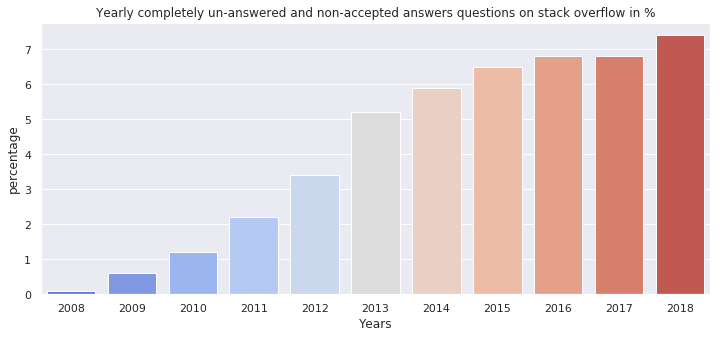

In [27]:
#yearly completely un-answered and non-accepted answers questions (Merged) on stack overflow
unansweredQ = """select EXTRACT(YEAR FROM creation_date) Years, count(*) UnAnsweredYearly,
ROUND(100*count(*)/16867398,1) as percentage from `bigquery-public-data.stackoverflow.posts_questions` 
where id not in (SELECT distinct id  FROM `bigquery-public-data.stackoverflow.posts_questions`
where post_type_id = 1 and Accepted_Answer_Id is not null and EXTRACT(YEAR FROM creation_date) <= 2018 ) 
and post_type_id = 1  and EXTRACT(YEAR FROM creation_date) <= 2018
group by EXTRACT(YEAR FROM creation_date)"""

yearlyunansweredQ = stackoverflow.query_to_pandas(unansweredQ)
dfUsers  = pd.DataFrame(yearlyunansweredQ)
#dfUsers
#dfUsers.plot.bar()
ax = sns.barplot(x = "Years",y = "percentage",
data = yearlyunansweredQ,palette="coolwarm").set_title("Yearly completely un-answered and non-accepted answers questions on stack overflow in %")
sns.set(rc={'figure.figsize':(12,5)})


# Posted questions Vs Answered questions Vs un-answered questions
Total number of quesitons asked Vs remain un-answered questions throughout the years from 2008 to 2018 as 2019 is not finished yet to analyse. If a questions did not get accepted answer we should also considered it as an unasnwered questoins on Stack Overflow.

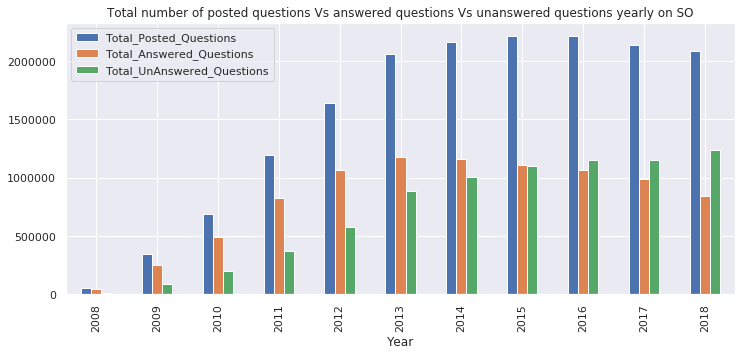

In [28]:
questions = """SELECT
  EXTRACT(YEAR FROM creation_date) AS Year,
  COUNT(*) AS Total_Posted_Questions,
  SUM(IF(answer_count > 0 and Accepted_Answer_Id is not null,1,0)) AS Total_Answered_Questions,
  SUM(IF(answer_count <= 0 or Accepted_Answer_Id is null ,1,0)) AS Total_UnAnswered_Questions
FROM `bigquery-public-data.stackoverflow.posts_questions`
where EXTRACT(YEAR FROM creation_date) <= 2018
GROUP BY Year
ORDER BY Year"""

yearlyallquestions = stackoverflow.query_to_pandas(questions)
dfUsers  = pd.DataFrame(yearlyallquestions)
#dfUsers
#dfUsers.plot.bar()
#ax = sns.barplot(x = "Years",y = "percentage",
#data = yearlyunansweredQ,palette="coolwarm").set_title("Yearly completely un-answered and non-accepted answers questions on stack overflow in %")

yearlyallquestions.plot(x="Year",y=["Total_Posted_Questions","Total_Answered_Questions","Total_UnAnswered_Questions"], 
kind="bar",figsize=(12,5),title='Total number of posted questions Vs answered questions Vs unanswered questions yearly on SO')




,Years,Questions Score,QuestionsCount,percentage,Questions Rate In Percentage,StringPercentatge
0,2008,Negative_Scored_Questions,369,0.635418,0.64,369\n\n(0.64%)
1,2008,Positive_Scored_Questions,51748,89.110070,89.11,51748\n\n(89.11%)
2,2008,Zero_Scored_Questions,5955,10.254512,10.25,5955\n\n(10.25%)
3,2009,Negative_Scored_Questions,4021,1.172525,1.17,4021\n\n(1.17%)
4,2009,Positive_Scored_Questions,251220,73.255865,73.26,251220\n\n(73.26%)


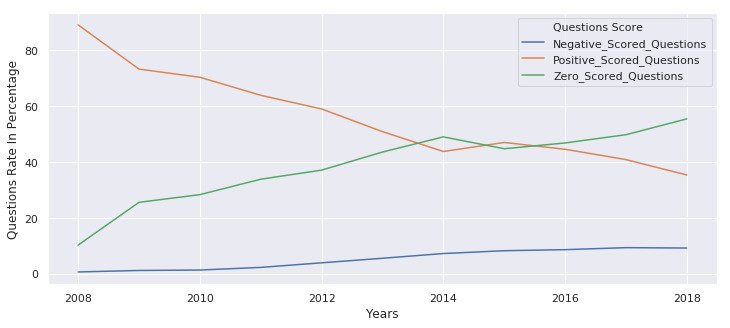

In [32]:
dfScoreofQuestions = pd.read_csv("../input/extracted-so-dataset/Questions Scores.csv")
sns.set(style="darkgrid")
sns.lineplot(x="Years", y="Questions Rate In Percentage", hue="Questions Score",data=dfScoreofQuestions) 
# we could also use directly *** allScores variable
sns.set(rc={'figure.figsize':(12,5)})
dfScoreofQuestions.head()

# Questions rate that scored positive, negative and zero score yearly
- For each questions we count the number of questions for yearly basis who scored positive, negative and zero score 


,Years,Answers Score,QuestionsCount,percentage,Answers Rate In Percentage,StringPercentatge
0,2008,Negative_Scored_Answers,4523,2.104044,2.10,4523\n \n (2.10%)
1,2008,Positive_Scored_Answers,162288,75.494380,75.49,162288\n \n (75.49%)
2,2008,Zero_Scored_Answers,48156,22.401580,22.40,48156\n \n (22.40%)
3,2009,Negative_Scored_Answers,16014,1.699903,1.70,16014\n \n (1.70%)
4,2009,Positive_Scored_Answers,681428,72.334280,72.33,681428\n \n (72.33%)


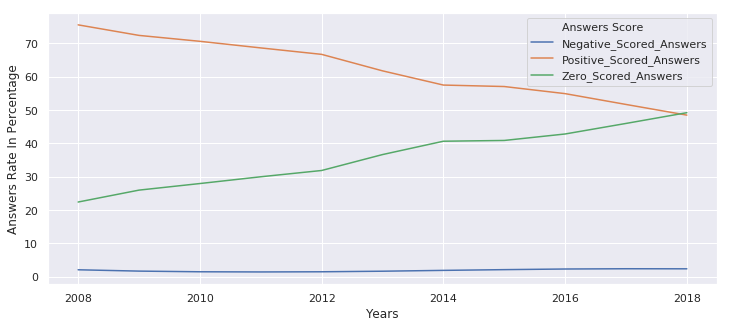

In [33]:
dfScoreofAnswers = pd.read_csv("../input/extracted-so-dataset/AnswersScores.csv")
sns.set(style="darkgrid")
sns.lineplot(x="Years", y="Answers Rate In Percentage", hue="Answers Score",data=dfScoreofAnswers) 
# we could also use directly *** allScores variable
sns.set(rc={'figure.figsize':(12,5)})
dfScoreofAnswers.head()

# Answers rate that scored positive, negative and zero score yearly
- For each answers we count the number of questions for yearly basis who scored positive, negative and zero score 

,Years,Comments Ratio Yearly,percentage,Yearly Comments Ratio in Percentage,StringPercentatge
0,2008,134937,0.314363,0.31,134937\n \n (0.31%)
1,2009,1227772,2.860344,2.86,1227772\n \n (2.86%)
2,2010,2496169,5.815332,5.82,2496169\n \n (5.82%)
3,2011,4708089,10.968450,10.97,4708089\n \n (10.97%)
4,2012,6875370,16.017570,16.02,6875370\n \n (16.02%)


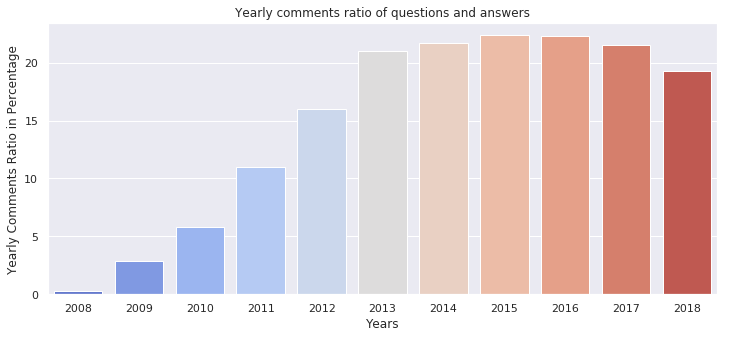

In [34]:
dfCommentsRatioYearly = pd.read_csv("../input/extracted-so-dataset/Comments Ratio Yearly.csv")
ax = sns.barplot(x = "Years",y = "Yearly Comments Ratio in Percentage",
data = dfCommentsRatioYearly,palette="coolwarm").set_title("Yearly comments ratio of questions and answers")
sns.set(rc={'figure.figsize':(12,5)})
dfCommentsRatioYearly.head()

#Change of discussion topic of top 20 tags on Stack Overflow from Questions
- we find top 20 tags that receive maximum number of questions over the years from questions. 


,Years,TagName,NumQuestions,percentage,Yearly percentage of Questions,StringPercentatge
0,2008,.net,4674,10.621520,10.62,4674\n \n (10.62%)
1,2008,android,28,0.063629,0.06,28\n \n (0.06%)
2,2008,arrays,305,0.693103,0.69,305\n \n (0.69%)
3,2008,asp.net,2863,6.506079,6.51,2863\n \n (6.51%)
4,2008,c,884,2.008863,2.01,884\n \n (2.01%)


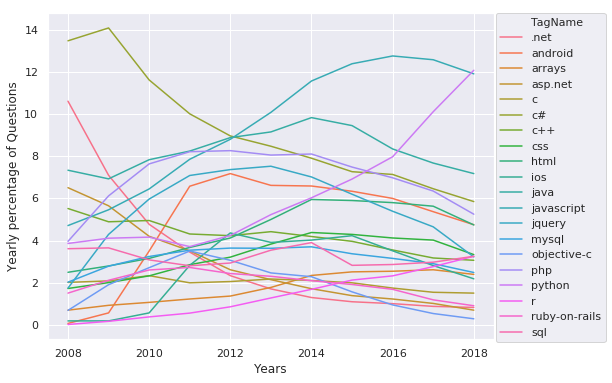

In [36]:
import matplotlib.pyplot as plt
# Show How topics of discssion has been changed over the years in terms of Questions
# I have analyzed this by studying top 20 tags who have received most questions over the years

dfTopTagsOfQuestions = pd.read_csv("../input/extracted-so-dataset/Yearly discussion of top 20 tags questions.csv")
sns.set(style="darkgrid")
sns.lineplot(x="Years", y="Yearly percentage of Questions", hue="TagName",data=dfTopTagsOfQuestions
            )
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.004, 1), loc=2, borderaxespad=0.)
sns.set(rc={'figure.figsize':(8,6)})
dfTopTagsOfQuestions.head()

#Change of discussion topic of top 20 tags on Stack Overflow from Answers
- we find top 20 tags that receive maximum number of answers over the years from answers. 

,Years,TagName,ANSWERNUMBER,percentage,Yearly Percentage of Answers,StringPercentatge
0,2008,.net,28877,13.438100,13.44,28877\n \n (13.44%)
1,2008,android,298,0.138676,0.14,298\n \n (0.14%)
2,2008,arrays,2736,1.273215,1.27,2736\n \n (1.27%)
3,2008,asp.net,15352,7.144153,7.14,15352\n \n (7.14%)
4,2008,c,8136,3.786141,3.79,8136\n \n (3.79%)


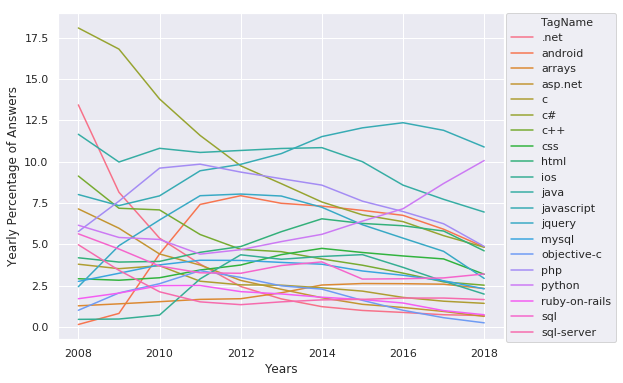

In [40]:
# Show, how topics of discssion has been changed over the years in terms of Answers
# I have analyzed this by studying top 20 tags who have received most Answers over the years
dfTopTagsOfAnswers = pd.read_csv("../input/extracted-so-dataset/Yearly discussion of top 20 tags answers.csv")
sns.set(style="darkgrid")
sns.lineplot(x="Years", y="Yearly Percentage of Answers", hue="TagName",data=dfTopTagsOfAnswers)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.004, 1), loc=2, borderaxespad=0.)
sns.set(rc={'figure.figsize':(8,6)})
dfTopTagsOfAnswers.head()

,Years,ReviewNumber,percentage,Yearly Percentage of Review,ReviewPercentage
0,2011,150717,1.117998,1.12,150717\n (1.12%)
1,2012,822745,6.103011,6.10,822745\n (6.1%)
2,2013,1549248,11.492110,11.49,1549248\n (11.49%)
3,2014,1751988,12.996010,13.00,1751988\n (13%)
4,2015,2516930,18.670250,18.67,2516930\n (18.68%)


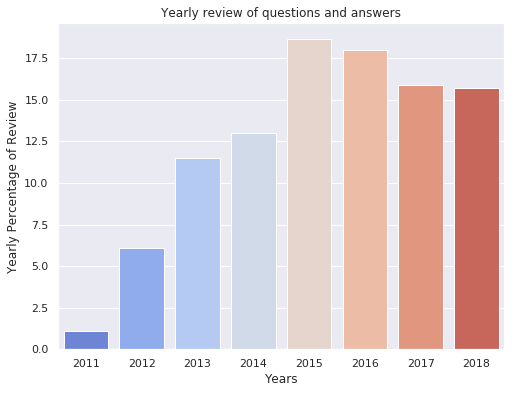

In [38]:
#Yearly review of questions and answers on Stack Overflow
dfReviewYearly = pd.read_csv("../input/extracted-so-dataset/Review Yearly.csv")
ax = sns.barplot(x = "Years",y = "Yearly Percentage of Review",
data = dfReviewYearly,palette="coolwarm").set_title("Yearly review of questions and answers")
sns.set(rc={'figure.figsize':(12,5)})
dfReviewYearly.head()